In [1]:
# 그리드 서치를 사용한 머신 러닝 모델 세부튜닝

import pandas as pd
import numpy as np
 
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve


In [6]:
# 그리드 서치를 사용한 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
              'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [7]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('test accuracy: %.3f' % clf.score(X_test, y_test))

test accuracy: 0.974


In [10]:
# 중첩 교차 검증을 사용한 알고리즘 선택
from sklearn.model_selection import cross_val_score

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('cv accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

cv accuracy: 0.974 +/- 0.015


In [12]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('cv accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

cv accuracy: 0.934 +/- 0.016


In [13]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


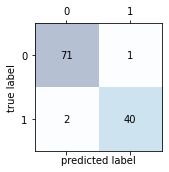

In [14]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('accuracy: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


accuracy: 0.976
재현율: 0.952
F1: 0.964


In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(solver='liblinear', penalty='l2', random_state=1, C=100.0))
X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))